In [2]:
import pandas as pd
import numpy as np
import joblib
import os
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from datetime import datetime
import json

# Load and prepare data
clinical_df = pd.read_csv("../data/processed/train_ready/clinical_df_v1.csv")
clinical_df.sort_values('timestamp', inplace=True)  

# Strategic features (removed patient_id)
features = [
    'hour',
    'is_night',
    'pm25_24h_avg',
    'no2_exceedance',
    'adherence_trend',
    'gema_risk_score',
    'district_risk',
    'age',
    'has_COPD'
]
target = 'puffs'

X = clinical_df[features]
y = clinical_df[target]

# Temporal split (60% train, 20% validation, 20% test)
n = len(X)
train_end = int(n * 0.6)
val_end = train_end + int(n * 0.2)

X_train, X_val, X_test = X.iloc[:train_end], X.iloc[train_end:val_end], X.iloc[val_end:]
y_train, y_val, y_test = y.iloc[:train_end], y.iloc[train_end:val_end], y.iloc[val_end:]

# Save datasets to folder
split_dir = "../data/processed/splits"
os.makedirs(split_dir, exist_ok=True)

pd.concat([X_train, y_train], axis=1).to_csv(f"{split_dir}/train_data.csv", index=False)
pd.concat([X_val, y_val], axis=1).to_csv(f"{split_dir}/val_data.csv", index=False)
pd.concat([X_test, y_test], axis=1).to_csv(f"{split_dir}/test_data.csv", index=False)

# Load model_config
with open("../config/model_config.json", "r") as f:
    params = json.load(f)

# Initialize the model
model = XGBRegressor(**params)

# Train with validation monitoring
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

# Final evaluation on test set
y_pred = model.predict(X_test)
print(f"\nTest Performance:")
print(f"- MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"- R²: {r2_score(y_test, y_pred):.2f}")

# Clinical utility check
accuracy_within_2 = np.mean(np.abs(y_test - y_pred) <= 2)
print(f"- Predictions within ±2 puffs: {accuracy_within_2:.1%}")

# Save model with timestamp
model_dir = "../model/experiments"
os.makedirs(model_dir, exist_ok=True)
model_path = f"{model_dir}/xgb_{datetime.now().strftime('%Y%m%d-%H%M')}_mae_{mean_absolute_error(y_test, y_pred):.1f}.pkl"
joblib.dump(model, model_path)
print(f"\nModel saved to: {model_path}")

[0]	validation_0-mae:0.77287
[1]	validation_0-mae:0.75654
[2]	validation_0-mae:0.74467
[3]	validation_0-mae:0.73447
[4]	validation_0-mae:0.72447
[5]	validation_0-mae:0.71852
[6]	validation_0-mae:0.70658
[7]	validation_0-mae:0.69521
[8]	validation_0-mae:0.69310
[9]	validation_0-mae:0.68840
[10]	validation_0-mae:0.68126
[11]	validation_0-mae:0.67407
[12]	validation_0-mae:0.66541
[13]	validation_0-mae:0.65997
[14]	validation_0-mae:0.65645
[15]	validation_0-mae:0.65130
[16]	validation_0-mae:0.64362
[17]	validation_0-mae:0.63828
[18]	validation_0-mae:0.63140
[19]	validation_0-mae:0.62543
[20]	validation_0-mae:0.61935
[21]	validation_0-mae:0.61369
[22]	validation_0-mae:0.61185
[23]	validation_0-mae:0.60996
[24]	validation_0-mae:0.60806
[25]	validation_0-mae:0.60322
[26]	validation_0-mae:0.59878
[27]	validation_0-mae:0.59602
[28]	validation_0-mae:0.59220
[29]	validation_0-mae:0.58979
[30]	validation_0-mae:0.58779
[31]	validation_0-mae:0.58591
[32]	validation_0-mae:0.58276
[33]	validation_0-ma

In [7]:
# Clinical evaluation
preds = model.predict(X_test)
print(f'MAE: {mean_absolute_error(y_test, preds):.2f} puffs/hour')
print(f'R²: {r2_score(y_test, preds):.2f}')

# Feature importance for decision-making
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

MAE: 0.53 puffs/hour
R²: 0.44


/tmp/ipykernel_16760/313985121.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance.head(10), palette='viridis')


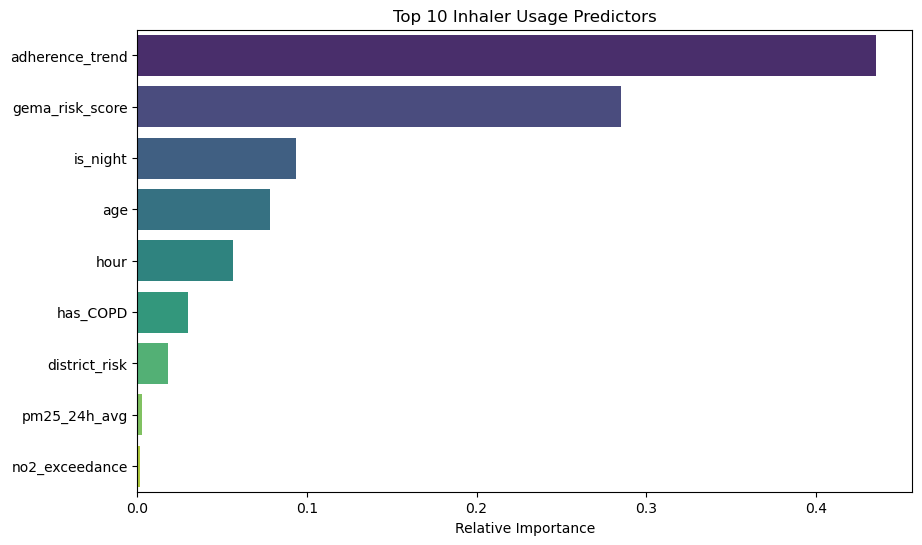

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10), palette='viridis')
plt.title('Top 10 Inhaler Usage Predictors')
plt.xlabel('Relative Importance')
plt.ylabel('')
# plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()